<a href="https://colab.research.google.com/github/GVSU-CIS635/term-project-proposal-team_2/blob/main/CIS_635_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports and Settings**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import kagglehub
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [ ]:
# Set the default figure size for matplotlib plots to 15 inches wide by 6 inches tall
rcParams["figure.figsize"] = (15, 6)

# Increase the default font size of the titles in matplotlib plots to extra-extra-large
rcParams["axes.titlesize"] = "xx-large"

# Make the titles of axes in matplotlib plots bold for better visibility
rcParams["axes.titleweight"] = "bold"

# Set the default location of the legend in matplotlib plots to the upper left corner
rcParams["legend.loc"] = "upper left"

# Configure pandas to display all columns of a DataFrame when printed to the console
pd.set_option('display.max_columns', None)

# Configure pandas to display all rows of a DataFrame when printed to the console
pd.set_option('display.max_rows', None)

# **Data Collection & Preprocessing**


**Import Dataset**

In [ ]:
# Upload the file
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

# Read the file into a pandas DataFrame
df = pd.read_csv(f"{path}/cardio_train.csv", delimiter=";")

# Display number of rows of DataFrame
print('Number of rows = %d \n' % (df.shape[0]))

# Display the first 5 rows of the DataFrame
df.head()


100%|██████████| 742k/742k [00:00<00:00, 21.9MB/s]

Extracting files...


Number of rows = 70000 



,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


**Data Cleaning: Missing Values**

In [ ]:
# Find attributes with missing data and display values
count_missing_values = df.isna().sum()
print('Number of missing values: ')
print(count_missing_values)

# Display sample of missing values
if count_missing_values.empty:
    print(count_missing_values.head(3))
else:
    print('\nNo rows with missing values found.')

Number of missing values: 
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

No rows with missing values found.


**Data Cleaning: Duplicates**

In [ ]:
# Check for duplicate records
duplicates = df.duplicated()
print('\nNumber of duplicate records: %d' % (duplicates.sum()))


Number of duplicate records: 0


**Data Cleaning: Unit Conversion**

Converts 'age' from units of days to years to improve interpretability of results.



In [ ]:
# Divide values in 'age' by 365 and round to 1 decimal place
df['age'] = (df['age'] / 365).round(1)

# Display example of transformed values
print('Age in years\n')
print(df['age'].head())

Age in years

0    50.4
1    55.4
2    51.7
3    48.3
4    47.9
Name: age, dtype: float64


**Data Cleaning: Making biological sense**

Numerical features will first be cleaned to only include realistic values that make biological sense.




In [ ]:
# Print key for features and their units

features = {
    'age': 'years',
    'height': 'cm',
    'weight': 'kg',
    'ap_hi': 'mmHg',
    'ap_lo': 'mmHg'}


print("Features and their units:")
for feature, unit in features.items():
    print(f"{feature}: {unit}")

# Print minimum and maximum values for numerical features
print("\nMinimum values:\n",df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']].min())
print("\nMaximum values:\n",df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']].max())

Features and their units:
age: years
height: cm
weight: kg
ap_hi: mmHg
ap_lo: mmHg

Minimum values:
 age        29.6
height     55.0
weight     10.0
ap_hi    -150.0
ap_lo     -70.0
dtype: float64

Maximum values:
 age          65.0
height      250.0
weight      200.0
ap_hi     16020.0
ap_lo     11000.0
dtype: float64


**Data will be cleaned to include:**

Heights between 149cm and 171cm (approx. 4'11 to 7'0)

Weights between 38kg and 125kg (approx. 85lbs to 275lbs)

Systolic blood pressures (ap_hi) between 90mmHg and 180mmHg

Diastolic blood pressures (ap_lo) beween 60mmHg and 120mmHg


---


**Sources:**

[Average height for women](https://health.clevelandclinic.org/what-is-the-average-height-for-women)

[Average height for men](https://health.clevelandclinic.org/what-is-the-average-height-for-a-man)

[Ideal weight chart](https://www.bannerhealth.com/staying-well/health-and-wellness/fitness-nutrition/ideal-weight)

[Blood pressure ranges](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings)

[Low blood pressure](https://my.clevelandclinic.org/health/diseases/21156-low-blood-pressure-hypotension)



In [ ]:
# Remove records with heights below 149cm and above 171cm
df = df[(df['height'] >= 149) & (df['height'] <= 171)]

# Remove records with weights below 38kg and above 125kg
df = df[(df['weight'] >= 38) & (df['weight'] <= 125)]

# Remove records with negative blood pressure values
df = df[(df['ap_hi'] > 0) & (df['ap_lo'] > 0)]

# Reomove records where ap_hi is below 90 or above 180
df = df[(df['ap_hi'] >= 90) & (df['ap_hi'] <= 180)]

# Remove records where ap_lo is below 60 or above 120
df = df[(df['ap_lo'] >= 60) & (df['ap_lo'] <= 120)]

# Print new minimum and maximum values for numerical features
print("\nNew minimum values:\n",df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']].min())
print("\nNew maximum values:\n",df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']].max())

# Display number of rows of DataFrame
print('\nNumber of rows remaining = %d \n' % (df.shape[0]))


New minimum values:
 age        29.8
height    149.0
weight     38.0
ap_hi      90.0
ap_lo      60.0
dtype: float64

New maximum values:
 age        64.9
height    171.0
weight    125.0
ap_hi     180.0
ap_lo     120.0
dtype: float64

Number of rows remaining = 55176 



**Data Cleaning: Outliers**

Outliers will be detected and removed using the 1.5x IQR method.

In [ ]:
# IQR = Q3 [.75] - Q1 [.25]

# Specify columns to include (numerical only)
columns = ['height', 'weight', 'ap_hi', 'ap_lo']

# Calculate quartiles
quantiles = df[columns].quantile([0.25, 0.5, 0.75], numeric_only=True)

# Display quartiles
print("\nQuartiles: \n",quantiles)

# Calculate IQR from quartiles
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]

# Print IQR table
print("\nInterquartile Range (IQR):\n",iqr)




Quartiles: 
       height  weight  ap_hi  ap_lo
0.25   158.0    63.0  120.0   80.0
0.50   163.0    70.0  120.0   80.0
0.75   167.0    80.0  140.0   90.0

Interquartile Range (IQR):
 height     9.0
weight    17.0
ap_hi     20.0
ap_lo     10.0
dtype: float64


In [ ]:
# Find outliers outside the 1.5xIQR range

# Define lower and upper bounds for outliers
lower_bound = quantiles.loc[0.25] - (1.5 * iqr)
print('Lower bounds:\n',lower_bound)

upper_bound = quantiles.loc[0.75] + (1.5 * iqr)
print('\n Upper bounds:\n',upper_bound)

# Find instances with values outside of bounds
outliers = df[
    ((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]

print('\nNumber of outliers = %d' % (outliers.shape[0]))

# Display outliers
outliers.head()

# Remove outliers from original dataframe
mask = df.apply(tuple, axis=1).isin(outliers.apply(tuple, axis=1))
df_cleaned = df[~mask]

# Display number of rows of DataFrame
print('\nNumber of rows = %d \n' % (df_cleaned.shape[0]))
df_cleaned.head()


Lower bounds:
 height    144.5
weight     37.5
ap_hi      90.0
ap_lo      65.0
dtype: float64

 Upper bounds:
 height    180.5
weight    105.5
ap_hi     170.0
ap_lo     105.0
dtype: float64

Number of outliers = 3989

Number of rows = 51187 



,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.4,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.4,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.7,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.3,2,169,82.0,150,100,1,1,0,0,1,1
5,8,60.0,1,151,67.0,120,80,2,2,0,0,0,0


# **Exploratory Data Analysis**

**Descriptive Statistics**

In [ ]:
# Define descriptive_statistics function
def descriptive_statistics(df):

  # Define numerical columns and their values
  num_columns = {
      'age': 'years',
      'height': 'cm',
      'weight': 'kg',
      'ap_hi': 'mmHg',
      'ap_lo': 'mmHg'
  }

  print("Descriptive Statistics for Numerical Columns:")

  # Calculate descriptive statistics for numeric attributes

  for column, unit in num_columns.items():
      if column in df.columns:
        mean_value = df[column].mean()
        median_value = df[column].median()
        maximum_value = df[column].max()
        minimum_value = df[column].min()
        std_dev = df[column].std()

        # Print descriptive statistics for each attribute
        print(f"\nDescriptive Statistics for {column} ({unit}):")
        print(f" Mean: {mean_value:.2f} {unit}")
        print(f" Median: {median_value:.2f} {unit}")
        print(f" Maximum: {maximum_value:.2f} {unit}")
        print(f" Minimum: {minimum_value:.2f} {unit}")
        print(f" Standard Deviation: {std_dev:.2f} {unit}")

      else:
        print(f"\nColumn '{column}' not found in the DataFrame.")

   # Define categorical columns

  print("""\nKey for categorical attributes:
  cholesterol | 1: normal, 2: above normal, 3: well above normal
  gluc | 1: normal, 2: above normal, 3: well above normal
  gender | 1: female, 2: male
  smoke | binary
  alco | binary
  active | binary
  cardio | binary """)

  cat_columns = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
  df_categorical=df.select_dtypes(include=['object', 'category'])
  print("\nDescriptive Statistics for Categorical Columns:")
  df_categorical = df[cat_columns]

  # Find counts for categorical attributes
  for column in df_categorical.columns:
    value_counts = df_categorical[column].value_counts()

    # Print counts for each categorical attribute
    print(f"\nDescriptive Statistics for '{column}':")
    print(f"Unique Values: {value_counts.index.tolist()}")
    print(f"Counts of Values:\n{value_counts}")




descriptive_statistics(df_cleaned)

Descriptive Statistics for Numerical Columns:

Descriptive Statistics for age (years):
 Mean: 53.55 years
 Median: 54.10 years
 Maximum: 64.90 years
 Minimum: 29.80 years
 Standard Deviation: 6.69 years

Descriptive Statistics for height (cm):
 Mean: 162.38 cm
 Median: 163.00 cm
 Maximum: 171.00 cm
 Minimum: 149.00 cm
 Standard Deviation: 5.55 cm

Descriptive Statistics for weight (kg):
 Mean: 71.80 kg
 Median: 70.00 kg
 Maximum: 105.50 kg
 Minimum: 38.00 kg
 Standard Deviation: 11.83 kg

Descriptive Statistics for ap_hi (mmHg):
 Mean: 126.27 mmHg
 Median: 120.00 mmHg
 Maximum: 170.00 mmHg
 Minimum: 90.00 mmHg
 Standard Deviation: 14.32 mmHg

Descriptive Statistics for ap_lo (mmHg):
 Mean: 81.59 mmHg
 Median: 80.00 mmHg
 Maximum: 105.00 mmHg
 Minimum: 65.00 mmHg
 Standard Deviation: 7.68 mmHg

Key for categorical attributes:
  cholesterol | 1: normal, 2: above normal, 3: well above normal
  gluc | 1: normal, 2: above normal, 3: well above normal
  gender | 1: female, 2: male
  smoke | 

**Visual Inspection of Data**

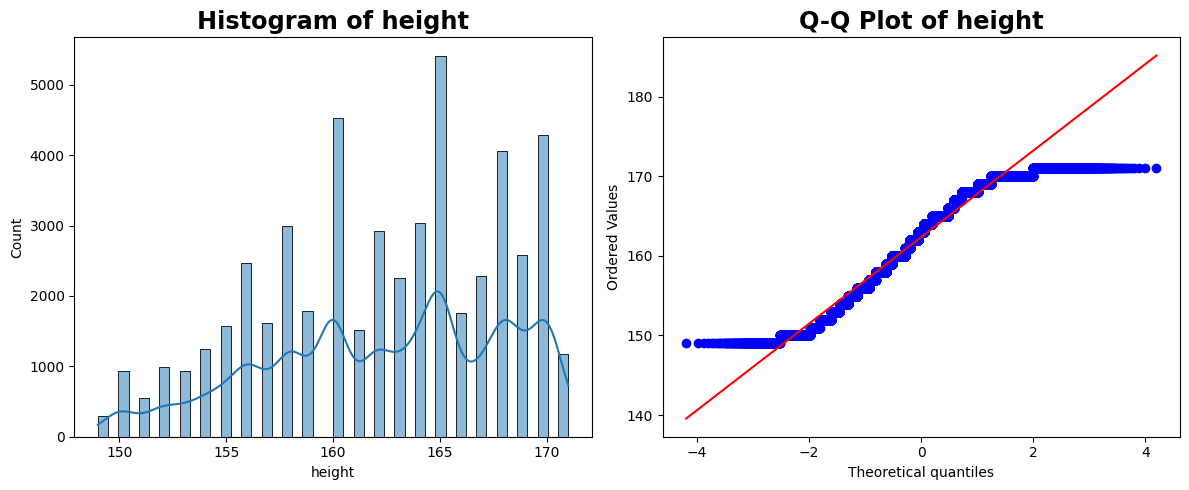

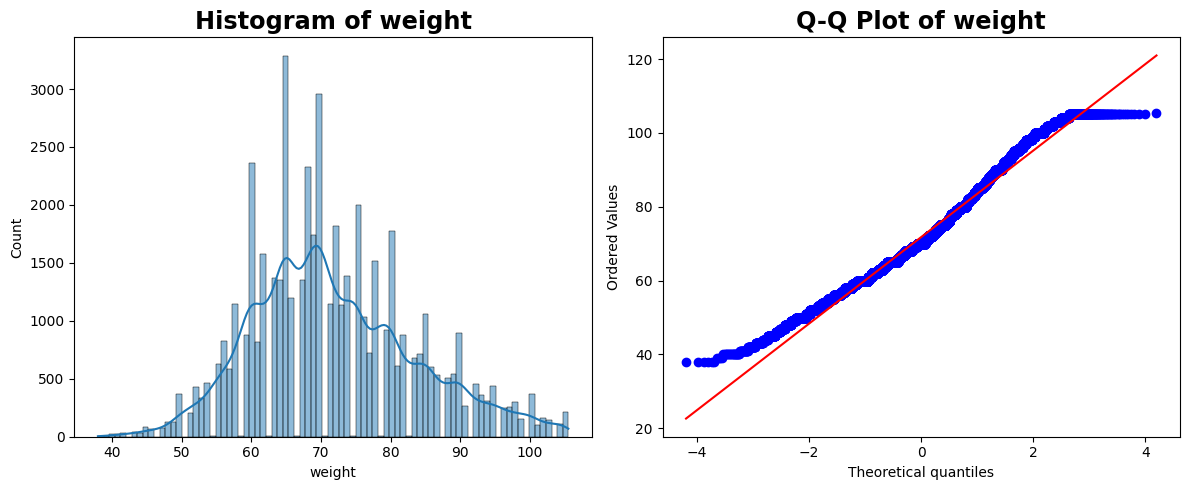

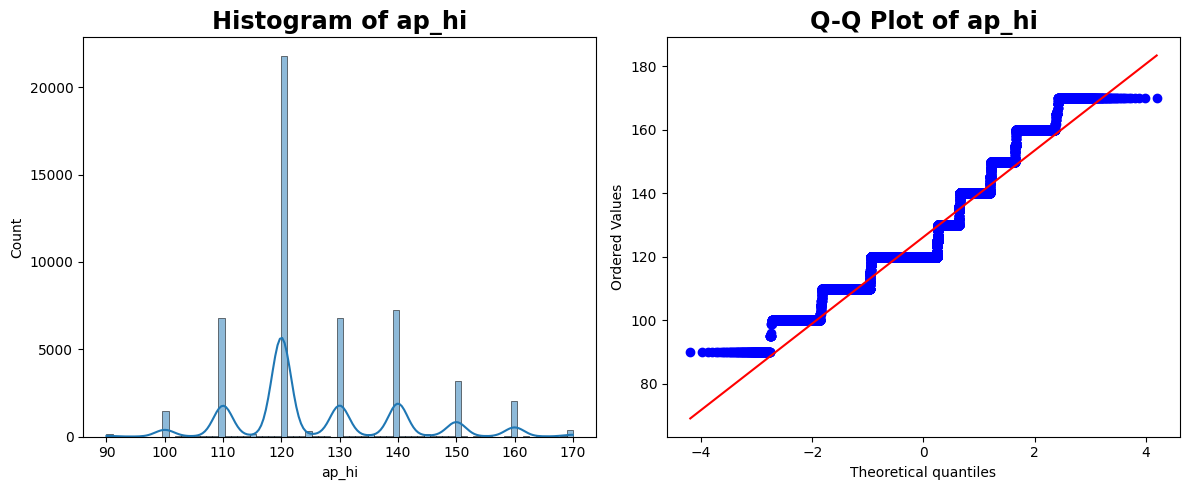

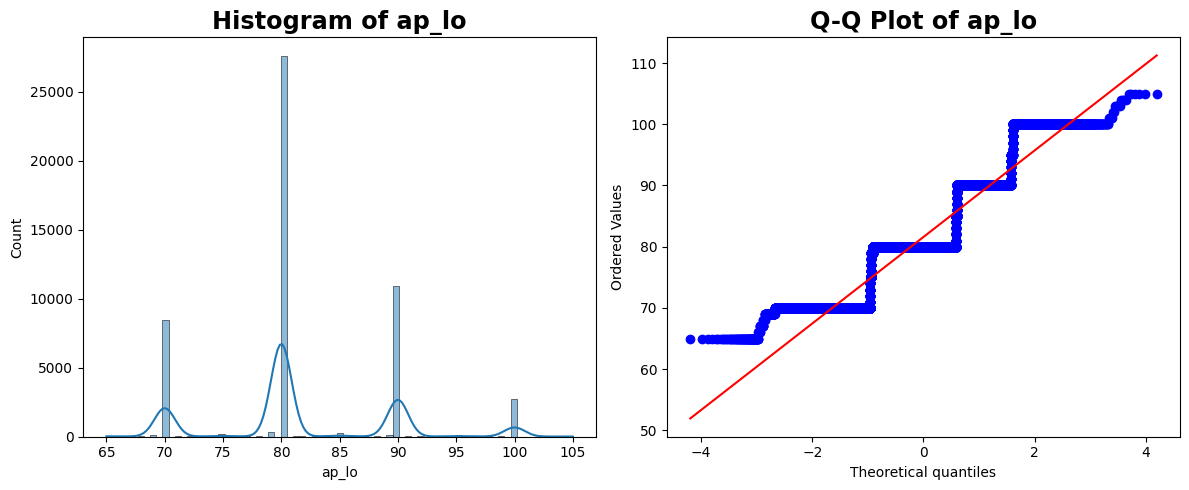

In [ ]:
# Specify columns to include
columns = ['height', 'weight', 'ap_hi', 'ap_lo']

# Plot histograms and Q-Q plots for each column
for col in columns:
    plt.figure(figsize=(12, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df_cleaned[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')

    plt.tight_layout()
    plt.show()

# **Modeling & Evaluation**

**Logistic Regression**

Model Construction & Hyperparameter Tuning

In [ ]:
# Use logistic regression to predict outcome variable based on all 11 predictor variables

# Define predictor variables
X = df_cleaned[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender']]

# Define outcome variable
y = df_cleaned['cardio'] # Binary target: 0 = No, 1 = Yes

# Split data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use sample of 20k records for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train_scaled, y_train, train_size=20000, random_state=42)

# Define paramter grid
lgr_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
}

# Initialize logistic regression model
logreg_model = LogisticRegression(max_iter=1000)

# Initialize random grid search
grid_search = GridSearchCV(
    estimator=logreg_model,
    param_grid=lgr_grid,
    scoring='f1',  # Optimize for F1-score
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Perform grid search on training data
grid_search.fit(X_sample, y_sample)

# Display best parameters
print("Best Parameters for Logistic Regression Model:", grid_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Logistic Regression Model: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Model Evaluation

        age  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
66596  55.6     155    65.0    110     80            1     1      0     0   
62200  56.0     171    92.0    140     90            3     3      0     0   
67715  48.6     164    60.0    110     70            1     1      1     1   
16360  62.1     160    58.0    130     80            2     1      0     0   
43566  50.2     165    60.0    120     80            1     1      0     0   

       active  gender  Actual  Predicted  
66596       1       1       0          0  
62200       1       2       0          1  
67715       0       2       0          0  
16360       1       1       1          1  
43566       0       1       0          0  


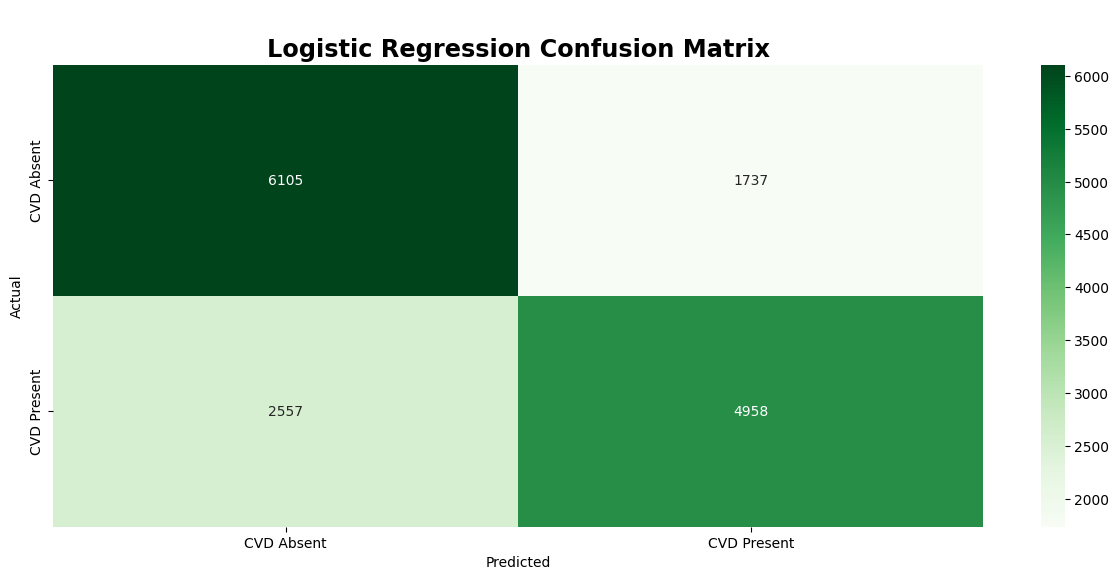


Logistic Regression Model Evaluation Metrics:
Accuracy: 0.720
Precision: 0.741
Recall (Sensitivity): 0.660
F1 Score: 0.698


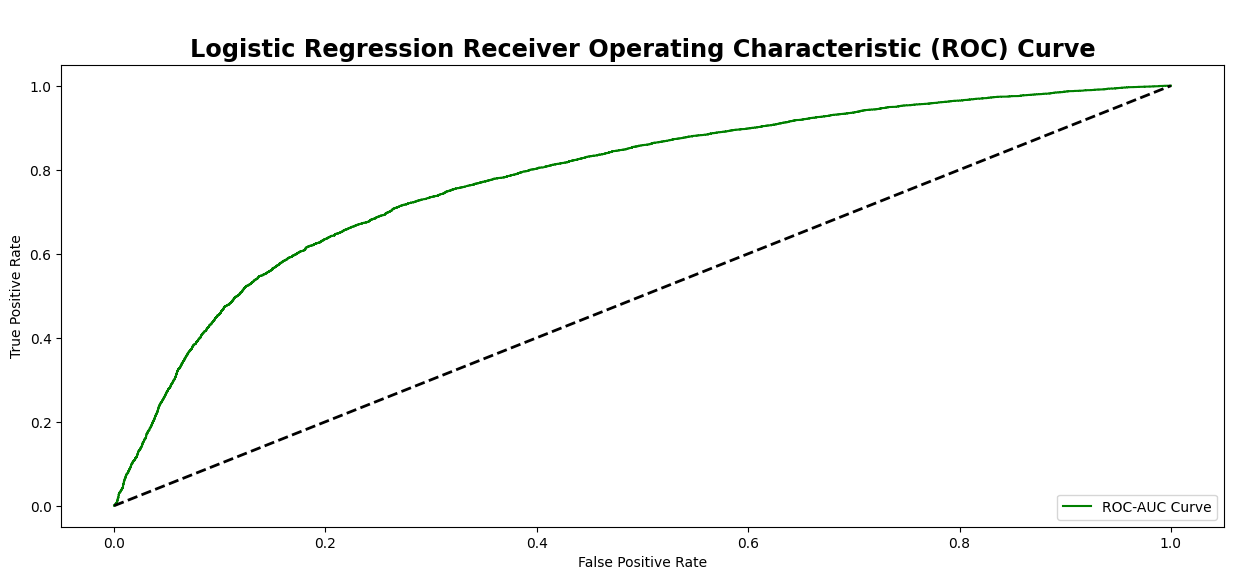

AUC Score: 0.782


In [ ]:
# Evaluate model based on best parameters

# Get best model
best_logreg = grid_search.best_estimator_

# Predict probabilities and classes
y_pred = best_logreg.predict(X_test_scaled)
y_pred_prob = best_logreg.predict_proba(X_test_scaled)[:, 1]

# Display predicted class labels alongside corresponding test data
logreg_results = X_test.copy()
logreg_results['Actual'] = y_test
logreg_results['Predicted'] = y_pred

print(logreg_results.head())

# Construct confusion matrix
logreg_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['CVD Absent', 'CVD Present'], yticklabels=['CVD Absent', 'CVD Present'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('\nLogistic Regression Confusion Matrix')
plt.show()

# Evaluate model using accuracy, precision, recall (sensitivity), and F1 score
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_precision = precision_score(y_test, y_pred)
logreg_recall = recall_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred)

print("\nLogistic Regression Model Evaluation Metrics:")
print(f"Accuracy: {logreg_accuracy:.3f}")
print(f"Precision: {logreg_precision:.3f}")
print(f"Recall (Sensitivity): {logreg_recall:.3f}")
print(f"F1 Score: {logreg_f1:.3f}")

# Calculate ROC curve
logreg_fpr, logreg_tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC score
logreg_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC-AUC curve
plt.figure()
plt.plot(logreg_fpr, logreg_tpr, label = 'ROC-AUC Curve', color='green')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('\nLogistic Regression Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {logreg_auc:.3f}")




Feature Importance

In [ ]:
# Use the best logistic regression model to determine which features are the most influential

# Get best model
best_logreg = grid_search.best_estimator_

# Get feature names
feature_names = X.columns

# Get feature coefficients
coefficients = best_logreg.coef_[0]

# Create dataframe
feature_importance = pd.DataFrame({'Feature': feature_names,
                                      'Coefficient': coefficients,
                                      'Absolute Coefficients': np.abs(coefficients)
                                      })

# Sort by absolute value of coefficients
feature_importance = feature_importance.sort_values(by='Absolute Coefficients', ascending=False)

# Display feature importance
print("Feature Importance for Logistic Regression\n")
print(feature_importance)


Feature Importance for Logistic Regression

        Feature  Coefficient  Absolute Coefficients
3         ap_hi     0.902579               0.902579
5   cholesterol     0.366746               0.366746
0           age     0.364683               0.364683
2        weight     0.137023               0.137023
4         ap_lo     0.126045               0.126045
9        active    -0.094418               0.094418
6          gluc    -0.082455               0.082455
7         smoke    -0.043779               0.043779
10       gender    -0.018887               0.018887
1        height     0.013707               0.013707
8          alco    -0.009634               0.009634


**Decision Tree**

Model Construction & Hyperparameter Tuning

In [ ]:
# Using decision tree to predict outcome variable based on the predictor variables

# Define predictor variables
X = df_cleaned[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender']]

# Define outcome variable
y = df_cleaned['cardio']  # Binary target: 0 = No, 1 = Yes

# Split data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use sample of 20k records for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train_scaled, y_train, train_size=20000, random_state=42)

# Define parameter grid
dt_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features':['sqrt', 'log2', None]}

# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Initialize grid search
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform grid search on training data
grid_search_dt.fit(X_sample, y_sample)

# Display best parameters
print("Best Parameters for Decision Tree Model:", grid_search_dt.best_params_)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters for Decision Tree Model: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


Model Evaluation

        age  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
66596  55.6     155    65.0    110     80            1     1      0     0   
62200  56.0     171    92.0    140     90            3     3      0     0   
67715  48.6     164    60.0    110     70            1     1      1     1   
16360  62.1     160    58.0    130     80            2     1      0     0   
43566  50.2     165    60.0    120     80            1     1      0     0   

       active  gender  Actual  Predicted  
66596       1       1       0          0  
62200       1       2       0          1  
67715       0       2       0          0  
16360       1       1       1          1  
43566       0       1       0          0  


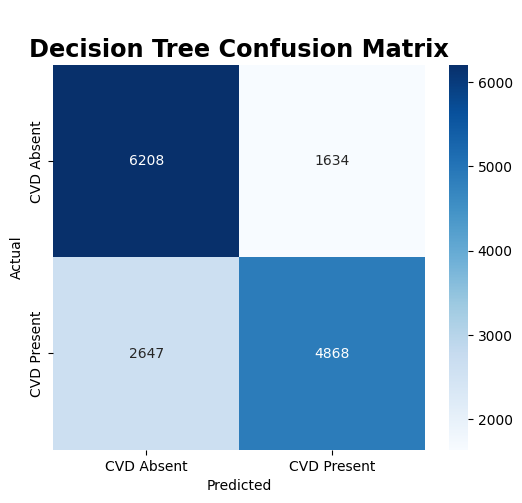


Decision Tree Model Evaluation Metrics:
Accuracy: 0.721
Precision: 0.749
Recall (Sensitivity): 0.648
F1 Score: 0.695


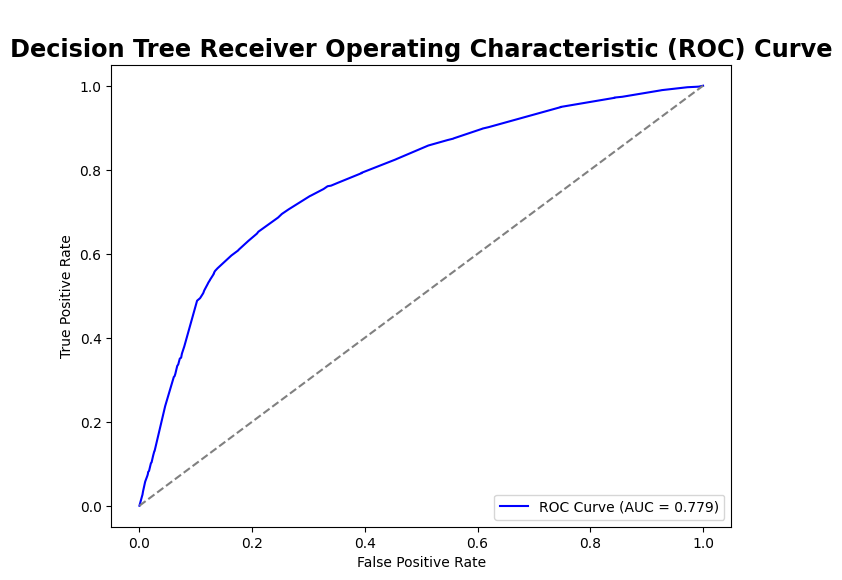

AUC Score: 0.779


In [ ]:
# Evaluate model based on best parameters

# Get best model
best_dt_model = grid_search_dt.best_estimator_

# Predict probabilities and classes
y_pred = best_dt_model.predict(X_test_scaled)
y_pred_prob = best_dt_model.predict_proba(X_test_scaled)[:, 1]


# Display predicted class labels alongside corresponding test data
dt_results = X_test.copy()
dt_results['Actual'] = y_test
dt_results['Predicted'] = y_pred

print(dt_results.head())

# Construct confusion matrix
dectree_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(dectree_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CVD Absent', 'CVD Present'], yticklabels=['CVD Absent', 'CVD Present'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('\nDecision Tree Confusion Matrix')
plt.show()

# Evaluate the model using accuracy, precision, recall and F1_score
dectree_accuracy = accuracy_score(y_test, y_pred)
dectree_precision = precision_score(y_test, y_pred)
dectree_recall = recall_score(y_test, y_pred)
dectree_f1 = f1_score(y_test, y_pred)

print("\nDecision Tree Model Evaluation Metrics:")
print(f"Accuracy: {dectree_accuracy:.3f}")
print(f"Precision: {dectree_precision:.3f}")
print(f"Recall (Sensitivity): {dectree_recall:.3f}")
print(f"F1 Score: {dectree_f1:.3f}")

# Calculate ROC curve and AUC score
dectree_fpr, dectree_tpr, thresholds = roc_curve(y_test, y_pred_prob)
dectree_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC-AUC curve
plt.figure(figsize=(8, 6))
plt.plot(dectree_fpr, dectree_tpr, label=f'ROC Curve (AUC = {dectree_auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('\nDecision Tree Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC Score: {dectree_auc:.3f}")


Feature Importance

In [ ]:
# Use the best decision tree model to determine which features are the most influential

# Get best model
best_dt_model = grid_search_dt.best_estimator_

# Get feature names
feature_names = X.columns

# Get feature importances from decision tree
feature_importance = best_dt_model.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importance,
                                      'Absolute Coefficients': np.abs(feature_importance)
                                      })

# Sort by absolute value of coefficients
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficients', ascending=False)

# Display feature importance
print("Feature Importance for Decision Tree\n")
print(feature_importance_df)


Feature Importance for Decision Tree

        Feature  Importance  Absolute Coefficients
3         ap_hi    0.689107               0.689107
0           age    0.156380               0.156380
5   cholesterol    0.077211               0.077211
2        weight    0.030619               0.030619
1        height    0.014594               0.014594
4         ap_lo    0.010667               0.010667
9        active    0.010367               0.010367
6          gluc    0.008920               0.008920
10       gender    0.002135               0.002135
7         smoke    0.000000               0.000000
8          alco    0.000000               0.000000


In [ ]:
print("Tree Height:", best_dt_model.get_depth())  # Gets the depth of the tree
print("Tree Depth:", best_dt_model.get_n_leaves())  # Number of leaves (end nodes)


Tree Height: 7
Tree Depth: 110


**Random Forest**

Model Construction & Hyperparameter Tuning

In [ ]:
# Define predictor variables
X = df_cleaned[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender']]

# Define outcome variable
y = df_cleaned['cardio']

# Split data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use sample of 20k records for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train_scaled, y_train, train_size=20000, random_state=42)

# Define parameter grid
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10,],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
}

# Initialze model
rf_model = RandomForestClassifier(random_state=42)

# Initialize grid search
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1)

# Perform grid search on training data
grid_search_rf.fit(X_sample, y_sample)

# Display best parameters
print("Best Parameters for Random Forest Model:", grid_search_rf.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Random Forest Model: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Model Evaluation

        age  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
66596  55.6     155    65.0    110     80            1     1      0     0   
62200  56.0     171    92.0    140     90            3     3      0     0   
67715  48.6     164    60.0    110     70            1     1      1     1   
16360  62.1     160    58.0    130     80            2     1      0     0   
43566  50.2     165    60.0    120     80            1     1      0     0   

       active  gender  Actual  Predicted  
66596       1       1       0          0  
62200       1       2       0          1  
67715       0       2       0          0  
16360       1       1       1          1  
43566       0       1       0          0  


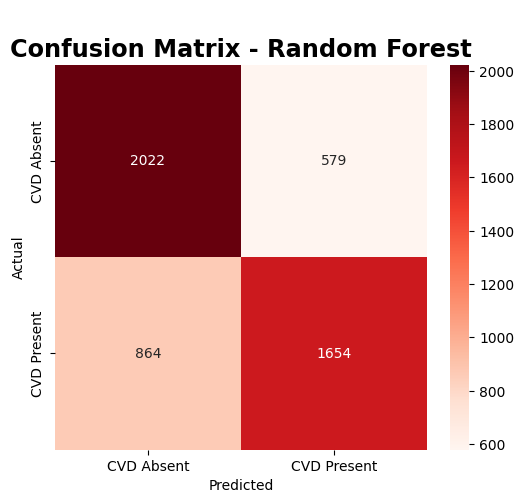


Random Forest Model Evaluation Metrics:
Accuracy: 0.718
Precision: 0.741
Recall (Sensitivity): 0.657
F1 Score: 0.696


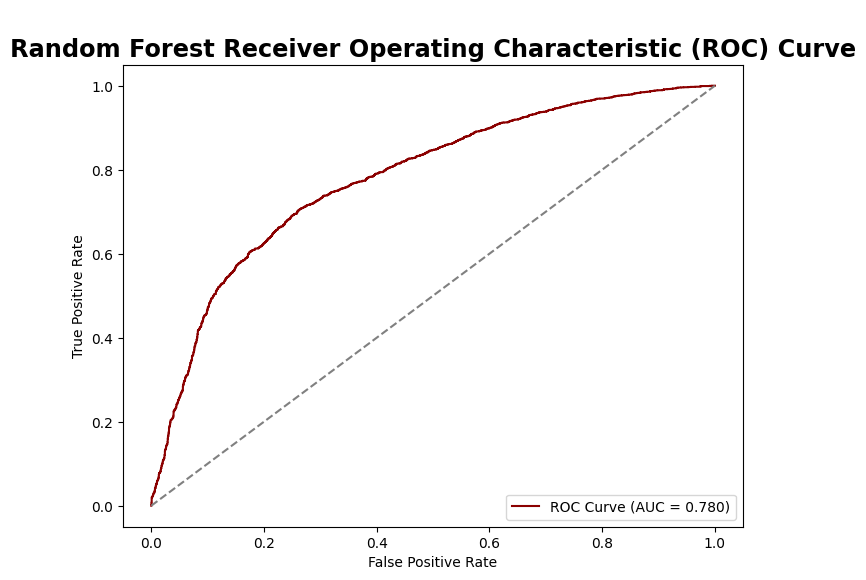

AUC Score: 0.780


In [ ]:
# Evaluate model based on best parameters

# Get best model
best_rf_model = grid_search_rf.best_estimator_

# Predict probabilities and classes
y_pred = best_rf_model.predict(X_test_scaled)
y_pred_prob = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Display predicted class labels alongside corresponding test data
rf_results = X_test.copy()
rf_results['Actual'] = y_test
rf_results['Predicted'] = y_pred

print(rf_results.head())

# Construct confusion matrix
rf_cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Reds', xticklabels=['CVD Absent', 'CVD Present'], yticklabels=['CVD Absent', 'CVD Present'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('\nConfusion Matrix - Random Forest')
plt.show()

# Evaluate the model using accuracy, precision, recall, and F1_score
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

print("\nRandom Forest Model Evaluation Metrics:")
print(f"Accuracy: {rf_accuracy:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall (Sensitivity): {rf_recall:.3f}")
print(f"F1 Score: {rf_f1:.3f}")

# Calculate ROC curve and AUC score
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_pred_prob)
rf_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC-AUC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'ROC Curve (AUC = {rf_auc:.3f})', color='darkred')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('\nRandom Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC Score: {rf_auc:.3f}")

Feature Importance

In [ ]:
# Get feature importances from best model

feature_importance = best_rf_model.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X.columns,
                                      'Importance': feature_importance,
                                      'Absolute Coefficients': np.abs(feature_importance)
                                      })

# Sort by absolute value of coefficients
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficients', ascending=False)

# Display feature importance
print("Feature Importance for Decision Tree\n")
print(feature_importance_df)

Feature Importance for Decision Tree

        Feature  Importance  Absolute Coefficients
3         ap_hi    0.420272               0.420272
0           age    0.164380               0.164380
4         ap_lo    0.158474               0.158474
5   cholesterol    0.080225               0.080225
2        weight    0.078843               0.078843
1        height    0.045376               0.045376
6          gluc    0.019032               0.019032
9        active    0.011213               0.011213
10       gender    0.008361               0.008361
7         smoke    0.007409               0.007409
8          alco    0.006414               0.006414


# **Model Comparison**

**Table of Metrics**

In [ ]:
# Create table comparing all models and their metrics

data = {
    "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "F1 Score", "AUC Score"],
    "Logistic Regression": [
        f"{logreg_accuracy:.3f}",
        f"{logreg_precision:.3f}",
        f"{logreg_recall:.3f}",
        f"{logreg_f1:.3f}",
        f"{logreg_auc:.3f}"
        ],
    "Decision Tree": [
        f"{dectree_accuracy:.3f}",
        f"{dectree_precision:.3f}",
        f"{dectree_recall:.3f}",
        f"{dectree_f1:.3f}",
        f"{dectree_auc:.3f}"
        ],
    "Random Forest": [
        f"{rf_accuracy:.3f}",
        f"{rf_precision:.3f}",
        f"{rf_recall:.3f}",
        f"{rf_f1:.3f}",
        f"{rf_auc:.3f}"
        ]
}

df_metrics = pd.DataFrame(data)

# Format with tabulate
formatted_table = tabulate(df_metrics, headers="keys", tablefmt="grid")

print(formatted_table)


+----+----------------------+-----------------------+-----------------+-----------------+
|    | Metric               |   Logistic Regression |   Decision Tree |   Random Forest |
+====+======================+=======================+=================+=================+
|  0 | Accuracy             |                 0.72  |           0.721 |           0.718 |
+----+----------------------+-----------------------+-----------------+-----------------+
|  1 | Precision            |                 0.741 |           0.749 |           0.741 |
+----+----------------------+-----------------------+-----------------+-----------------+
|  2 | Recall (Sensitivity) |                 0.66  |           0.648 |           0.657 |
+----+----------------------+-----------------------+-----------------+-----------------+
|  3 | F1 Score             |                 0.698 |           0.695 |           0.696 |
+----+----------------------+-----------------------+-----------------+-----------------+
|  4 | AUC

**Heatmap of Metric Values**

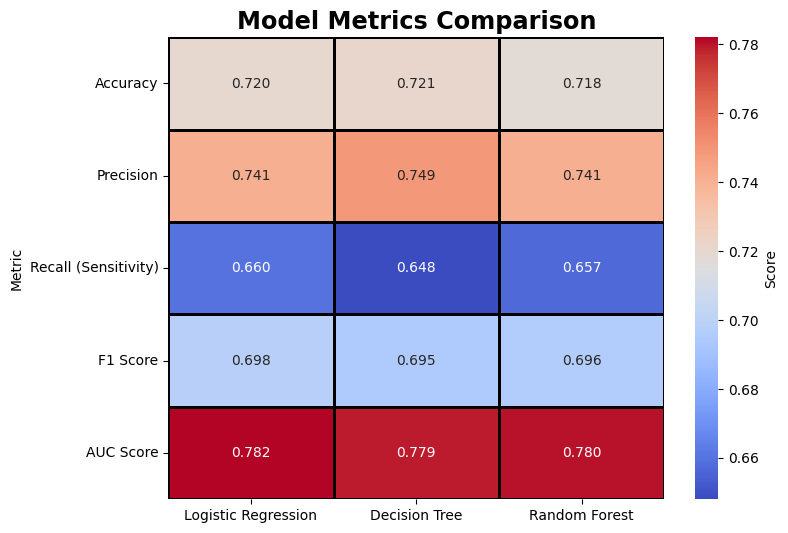

In [ ]:
# Convert values in metric table back to numeric type
metric_heatmap = df_metrics.copy()
for column in df_metrics.columns[1:]:
  metric_heatmap[column] = pd.to_numeric(df_metrics[column])

# Create DataFrame for heatmap
heatmap_data = metric_heatmap.set_index("Metric")

# Plot heatmap with borders
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=1, linecolor="black", cbar_kws={'label': 'Score'})
plt.title("Model Metrics Comparison")
plt.show()


**ROC Curve Overlay**

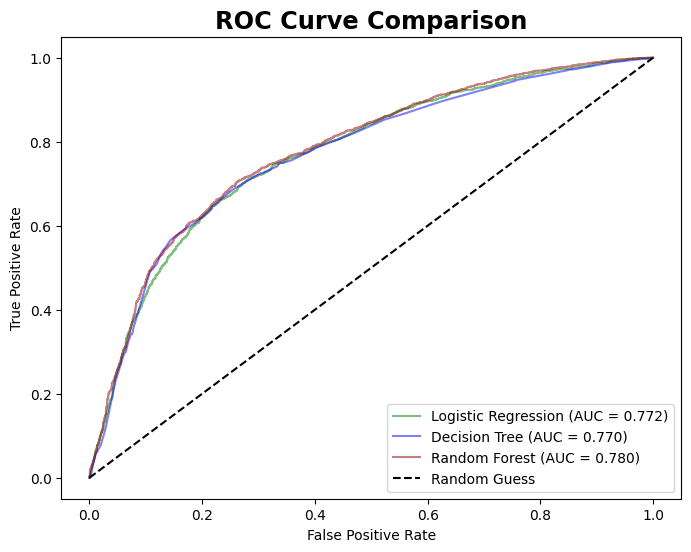

In [ ]:
plt.figure(figsize=(8, 6))

# ROC curves
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.3f})', color='green', alpha=0.5)
plt.plot(dectree_fpr, dectree_tpr, label=f'Decision Tree (AUC = {dectree_auc:.3f})', color='blue', alpha=0.5)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', color='darkred', alpha=0.5)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()
